In [ ]:
import pandas as pd
from rdkit import Chem

In [ ]:
#Reading ChemFluor dataset
df = pd.read_csv('Alldata_SMILES_v0.1.csv')

#Removing excess columns (empty space, misc information)
df = df.iloc[:, :12]
df = df.iloc[:, 1:]

#Converting SMILES to universal canonical smiles format
df['canonical_smiles'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smiles)) for smiles in df['SMILES']]

#shape should be 4386 x 13
print(df.head(), df.shape)
df.shape

In [ ]:
#Checking the number of unique smile-solvent pairs.
# The dataset has some entries with the exact same SMILES structure and solvent but varying PLQY/absorption/emission values.
df['smile_solvent'] = df['canonical_smiles']+df['solvent']
df['smile_solvent'].nunique()


4336

In [ ]:
import matplotlib.pyplot as plt

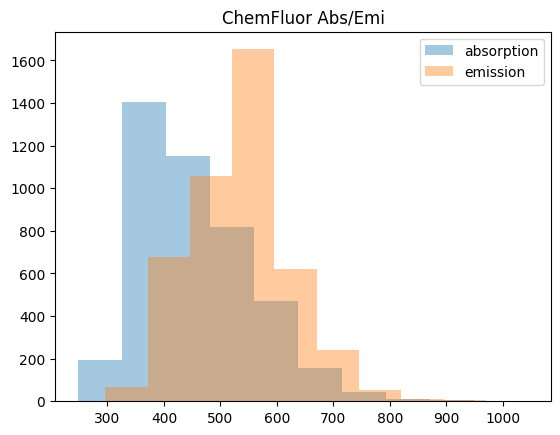

In [ ]:
#Plotting distribution of absorption/emission wavelengths in the dataset
plt.hist(df['Absorption/nm'], alpha=0.4, label='absorption')
plt.hist(df['Emission/nm'], alpha=0.4, label='emission')
plt.title("ChemFluor Abs/Emi")
plt.legend()
plt.savefig("chemfluor_abs_emi.png")

In [ ]:
# We trained separate models to predict absorption, emission, and PLQY respectively. Since some molecule-solvent pairs have data for some combination of
# absorption, emission, or PLQY but not measurements for all three, we made sure to curate three different datasets per task so that we could maximize our training data.
# Let's say a molecule-solvent pair had an absorption reading and emission reading but no PLQY reading. Curating different datasets per task ensured that that example was included
# in both the absorption and emission datasets, and would only be dropped in the PLQY dataset. Here we prep the absorption dataset and drop values for 
# molecule-solvent pairs that don't have associated absorption values.
df_abs = df[['canonical_smiles', 'SP', 'SdP', 'SA', 'SB', 'Absorption/nm']]
df_abs = df_abs.dropna()

In [ ]:
# As we mentioned earlier, there are some molecule-solvent pairs that have identical SMILES strings and solvent constants (SP, SdP, SA, SB) but 
# different absorption/emission/PLQY measurements. Thus, we average the values associated with these pairs to ensure no duplicate inputs to the model. 
df_abs_avg = df_abs.groupby(['canonical_smiles', 'SP', 'SdP', 'SA', 'SB']).agg({
    'Absorption/nm': 'mean',
}).reset_index()

df_abs_avg.to_csv("chemfluor_abs_train_solvents.csv")

In [ ]:
#Curating emission dataset on the same principles
df_emi = df[['canonical_smiles', 'SP', 'SdP', 'SA', 'SB', 'Emission/nm']]
df_emi = df_emi.dropna()

df_emi_avg = df_emi.groupby(['canonical_smiles', 'SP', 'SdP', 'SA', 'SB']).agg({
    'Emission/nm': 'mean'
}).reset_index()

df_emi_avg.to_csv("chemfluor_emi_train_solvents.csv")

In [ ]:
#Curating PLQY dataset based on the same principles. PLQY data is yet to be binarized at this point
df_plqy = df[['canonical_smiles', 'SP', 'SdP', 'SA', 'SB', 'PLQY']]
df_plqy = df_plqy.dropna()

df_plqy_avg = df_plqy.groupby(['canonical_smiles', 'SP', 'SdP', 'SA', 'SB']).agg({
    'PLQY': 'mean'
}).reset_index()

df_plqy_avg.to_csv("chemfluor_plqy_train_solvents.csv")

In [ ]:
#The number of NAs based on column
df.isna().sum(axis=0)

Absorption/nm        134
Emission/nm            0
PLQY                1296
SMILES                 0
solvent                0
Reference(doi)         0
Et30                   0
SP                     0
SdP                    0
SA                     0
SB                     0
canonical_smiles       0
dtype: int64